# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

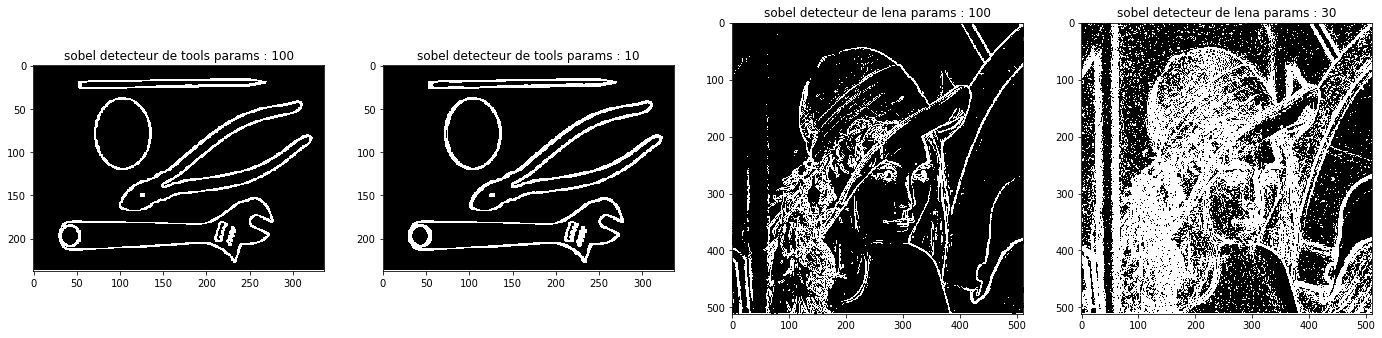

In [2]:
tools = np.array(Image.open("img/tools.png"))
lena = np.array(Image.open("img/lena.png"))

def SobelDetector(I, s):
    Ix = convolve2d(I,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
    Iy = convolve2d(I,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
    G = np.sqrt(Ix**2+Iy**2)
    return np.where(G>s,1,0)

niceDisplay14([SobelDetector(tools,100), SobelDetector(tools,10), SobelDetector(lena,100), SobelDetector(lena,30)],\
              ["sobel detecteur de tools params : 100", "sobel detecteur de tools params : 10",\
               "sobel detecteur de lena params : 100","sobel detecteur de lena params : 30"])

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

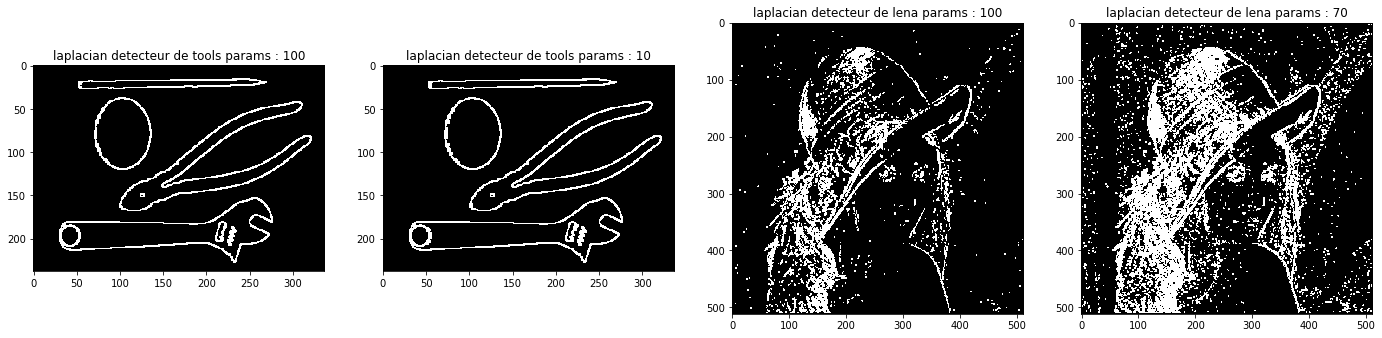

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    Il = convolve2d(I,[[0,1,0],[1,-4,1],[0,1,0]],mode='same')
    L = np.zeros(Il.shape)
    for x in range(1,len(Il)-1):
        for y in range(1,len(Il[x])-1):
            A = np.max(Il[x-1:x+2,y-1:y+2])
            B = np.min(Il[x-1:x+2,y-1:y+2])
            if A > 0 and B < 0 and A - B > s:
                L[x][y] = 1
            else:
                L[x][y] = 0
    return L
niceDisplay14([LaplacianDetector(tools,100), LaplacianDetector(tools,10),\
               LaplacianDetector(lena,100), LaplacianDetector(lena,70)],\
              ["laplacian detecteur de tools params : 100", "laplacian detecteur de tools params : 10",\
               "laplacian detecteur de lena params : 100","laplacian detecteur de lena params : 70"])

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

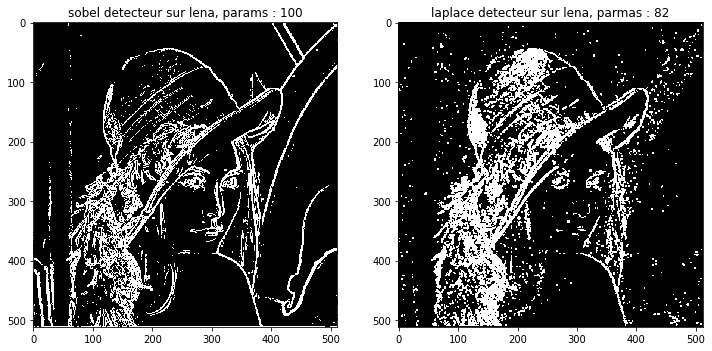

In [4]:
sobel_l = SobelDetector(lena,100)
laplace_l = LaplacianDetector(lena,82)
niceDisplay14([sobel_l, laplace_l],["sobel detecteur sur lena, params : 100","laplace detecteur sur lena, parmas : 82"])

On remarque que les contours détectés dans le sobel detecteur sont plus continue et plus franc que ceux détectés par le detecteur laplacien. On remarque aussi que le détecteur laplacian crée du bruit dans l'image.

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


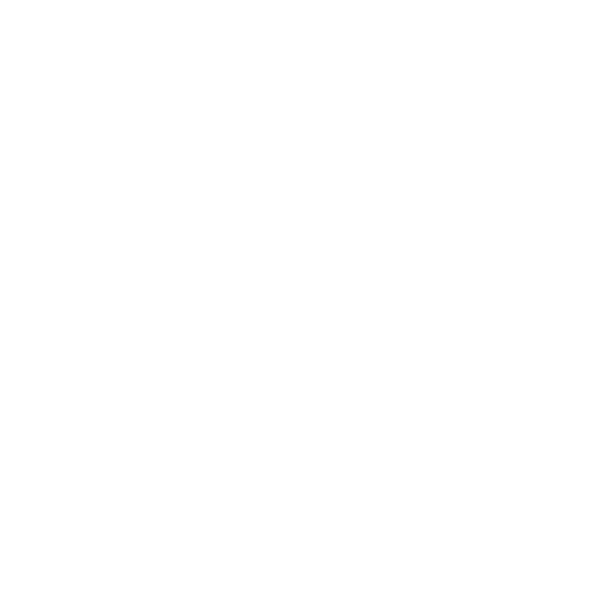

In [5]:
%matplotlib notebook

Ix = convolve2d(tools,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
Iy = convolve2d(tools,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
Ig = np.sqrt(Ix**2+Iy**2)
orient = orientation(Ix,Iy,Ig)
imshow_hot(orient)

Explain the different values given to a pixel by `orientation()`:

Les valeurs correspondent à l'orientation du gradient.
0 : gradient null -> pas d'orientation (couleur noire)   
1 : orientation horizontal (angle $0$, couleur rouge)  
2 : diagonale de en bas à gauche à en haut à droite (angle $\pi/4$, couleur orange)    
3 : orientation vertical (angle $\pi/2$, couleur jaune)   
4 : diagonale de en haut à gauche à en bas à droite (angle $3\pi/4$, couleur blanche)  

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [6]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    G = np.zeros(Ig.shape)
    for i in range(len(Ig)):
        for j in range(len(Ig[i])):
            orientation = Ior[i,j]

            if orientation == 1:
                # horizontal
                if j!=0 and Ig[i,j-1] <= Ig[i,j]:
                    if j!=len(Ig[i])-1 and Ig[i,j+1] <= Ig[i,j]:
                        G[i,j]=Ig[i,j]
                        
            elif orientation == 2:
                # en bas à gauche à en haut à droite
                if j!=len(Ig[i])-1 and i!=0 and Ig[i-1,j+1] <= Ig[i,j]:
                    if j!=0 and i!=len(Ig)-1 and Ig[i+1,j-1] <= Ig[i,j]:
                        G[i,j]=Ig[i,j]
            elif orientation==3:
                # vertical
                if i!=0 and Ig[i-1,j] <= Ig[i,j]:
                    if i!=len(Ig)-1  and Ig[i+1,j] <= Ig[i,j]:
                        G[i,j]=Ig[i,j]
                
            elif orientation == 4: 
                # en haut à gauche à en bas à droite
                if j!=0 and i!=0 and Ig[i-1,j-1] <= Ig[i,j]:
                    if j!=len(Ig[i])-1 and i!=len(Ig)-1 and Ig[i+1,j+1] <= Ig[i,j]:
                        G[i,j]=Ig[i,j]
    return G

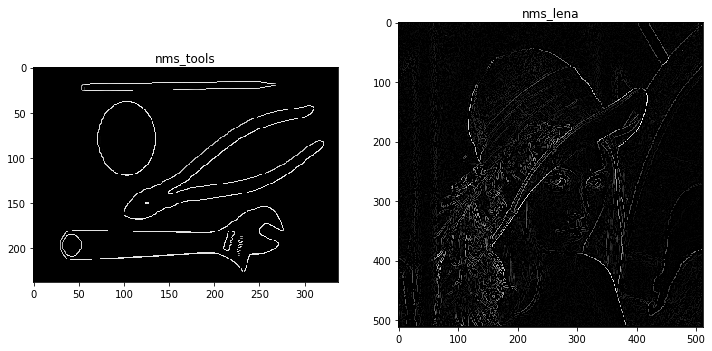

In [7]:
%matplotlib inline

def f_nms(img):
    Ix_l = convolve2d(img,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
    Iy_l = convolve2d(img,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
    Ig_l = np.sqrt(Ix_l**2+Iy_l**2)
    orient_l = orientation(Ix_l,Iy_l,Ig_l)
    return nms(Ig_l,orient_l)

G = f_nms(tools)
G_l = f_nms(lena)

niceDisplay14([G, G_l],["nms_tools","nms_lena"])

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


In [8]:
def applyGaussian(I,sigma):
    gk = gaussianKernel(sigma)
    return convolve2d(I,gk,mode='same')

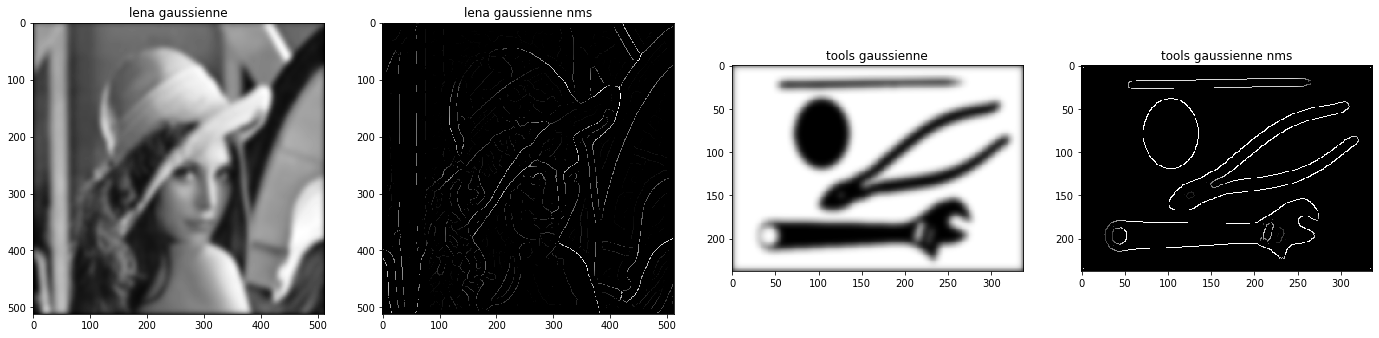

In [36]:


lena_k = applyGaussian(lena,5)
tools_k = applyGaussian(tools,4)
niceDisplay14([lena_k, f_nms(lena_k),tools_k, f_nms(tools_k)],\
              ['lena gaussienne', 'lena gaussienne nms','tools gaussienne', 'tools gaussienne nms'])

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Quand $\sigma$ est petit, les contours de l'image sont plus nets (des contours plus fin) mais plus sensible au bruit.  
Dans certain cas, on a du mal à détecter les bords si l'image est trop complexe, comme 'lena'. Laquelle possède trop de détails et donc nous rend une image de détection bruité.  
A son contraire, tools possède peut de détail, ces contours sont donc trés bien détecter avec un petit $\sigma$.  

Quand $\sigma$ est grand, l'image est plus floue, les bords sont moins marqués (des contours plus gros), ce qui nous permet une meilleur détection des contours de l'image 'lena'. La version smooth est plus lisible que l'originale par la détection nms car celle-ci est moins sensible au bruit.  

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

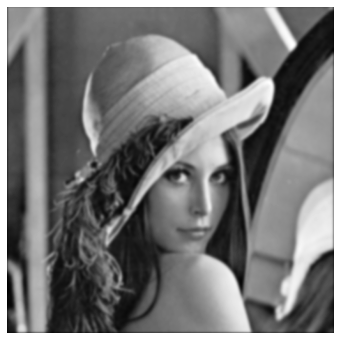

In [11]:
lena_g = applyGaussian(lena,2)
imshow(lena_g)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

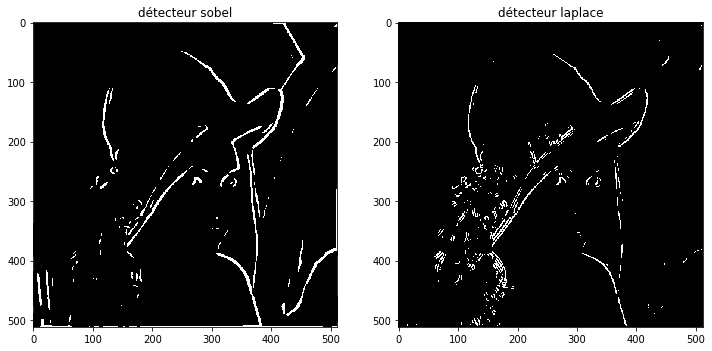

In [12]:
sobel_g = SobelDetector(lena_g,130)
laplace_g = LaplacianDetector(lena_g,10)
niceDisplay14([sobel_g, laplace_g],["détecteur sobel","détecteur laplace"])

On observe que les contours du detecteur sobel sont plus lisses, francs et continues que les contours laplacian.
On observe que les contours du detecteur laplacian sont plus sensibles au bruit et aux détails (on devine mieux la plume avec le detecteur laplacian qu'avec le detecteur sobel).

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

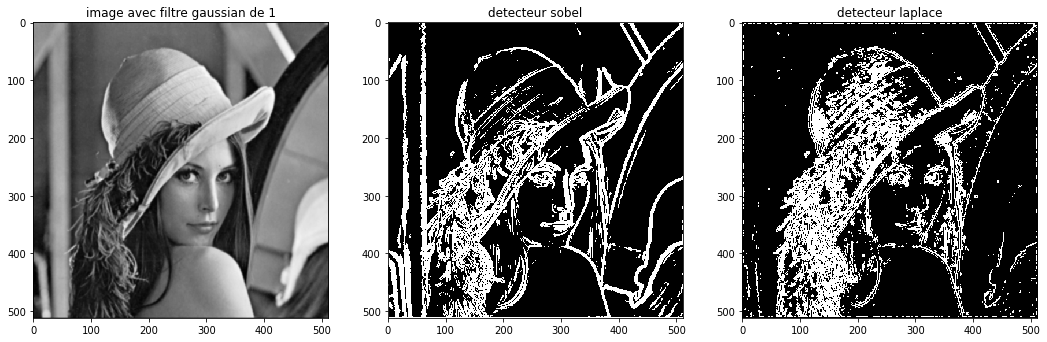

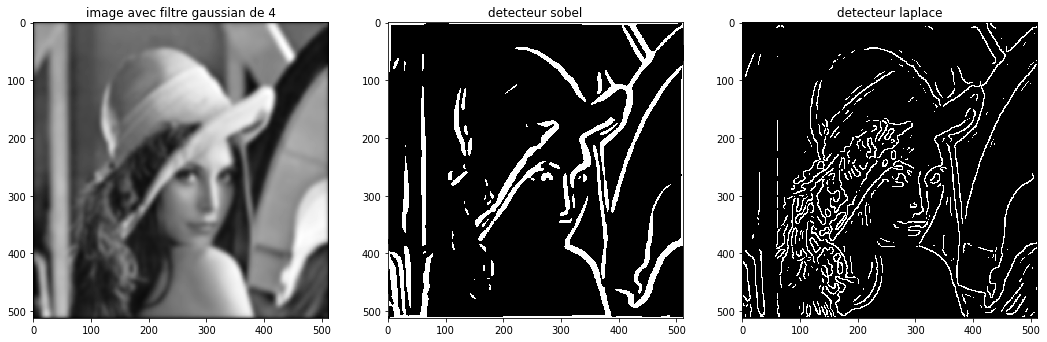

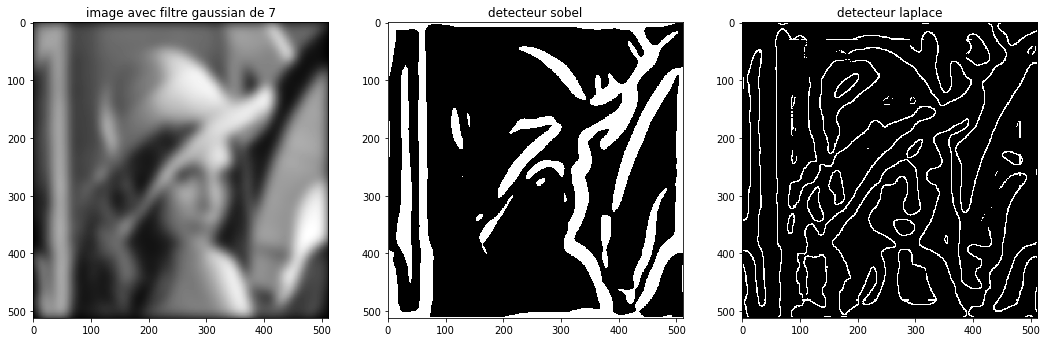

In [13]:
# sigma dans [1,10]
lena_g = applyGaussian(lena,1)
sobel_g = SobelDetector(lena_g,50)
laplace_g = LaplacianDetector(lena_g,10)
niceDisplay14([lena_g, sobel_g, laplace_g],["image avec filtre gaussian de 1", "detecteur sobel", "detecteur laplace"])

lena_g = applyGaussian(lena,4)
sobel_g = SobelDetector(lena_g,50)
laplace_g = LaplacianDetector(lena_g,0.5)
niceDisplay14([lena_g, sobel_g, laplace_g],["image avec filtre gaussian de 4", "detecteur sobel", "detecteur laplace"])

lena_g = applyGaussian(lena,10)
sobel_g = SobelDetector(lena_g,20)
laplace_g = LaplacianDetector(lena_g,0.01)
niceDisplay14([lena_g, sobel_g, laplace_g],["image avec filtre gaussian de 7", "detecteur sobel", "detecteur laplace"])

On fait varier $\sigma$ de 1 a 10 et on remarque deux comportements différents avec nos détecteurs.  
Plus on augmente $\sigma$ et plus les contours de l'image deviennent flous, ce qui se traduit pour le détecteur sobel par une baisse du nombre de contours et une augmentation de l'épaisseur (moins bien localisé) de ceux-ci.  
Dans le cas du détecteur laplacian, l'épaisseur des contours détectés sont toujours fins, mais ils ont tendance à représenter les formes de manière plus global au fur et à mesure que $\sigma$ augmente.

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

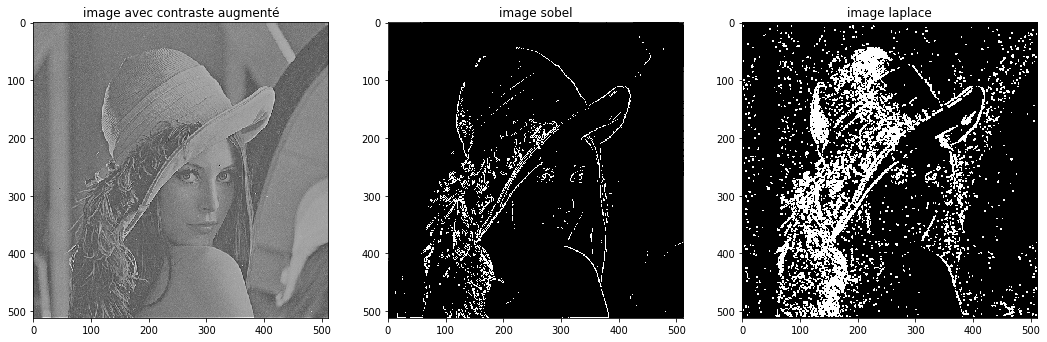

In [14]:
# filtre vu en TD : Exercice 11 question 2
filtre = (1/16)*np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
tmp = convolve2d(lena,filtre,mode='same')
sobel = SobelDetector(tmp,30)
laplace = LaplacianDetector(tmp,30)

niceDisplay14([tmp, sobel, laplace], ["image avec contraste augmenté", "image sobel", "image laplace"])

Le filtre augmentant le contraste et marque donc plus les contours.   
Avec le filtre Sobel, le seuillage nécéssaire est beaucoup plus bas, les valeurs entre les pixels étant beaucoup plus contrasté, la dérivée augmente proche des zones avec forte changement d'intensité (les bords) et réduit proche des zones avec faible changement d'intensité, on peut donc réduire le seuillage car les valeurs du detecteur de sobel n'étant pas des bords sont plus faibles.     
Avec le filtre de Laplace, il faut mettre un seuillage du bruit plus fort car le filtre va augmenter le contraste du bruit avec le reste des pixels, ce qui se traduit avec le filtre de Laplace à une forte différence entre les pixels proches et les pixels de bruit, il faut donc mettre un seuil plus important pour supprimer le bruit.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [15]:
def multi_resolution(img, g, all_img = False):
    x = np.log(img.shape[0])/np.log(2)
    if x != int(x):
        #img n'est pas une puissance de 2, donc on ne peut la réduire à une taille (8,8)
        return None
    
    ret_img = img.copy()
    seq = [ret_img]
    
    while ret_img.shape[0] > 8:
        ret_img = applyGaussian(ret_img,g)[::2,::2]
        seq += [ret_img]
    
    if all_img:
        return seq
    return ret_img

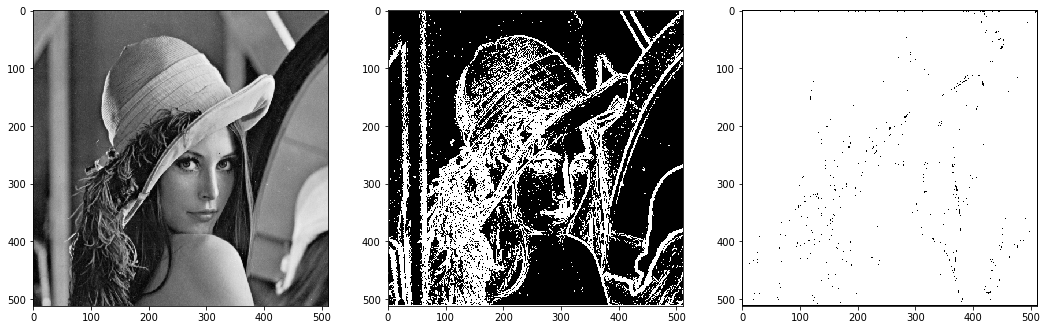

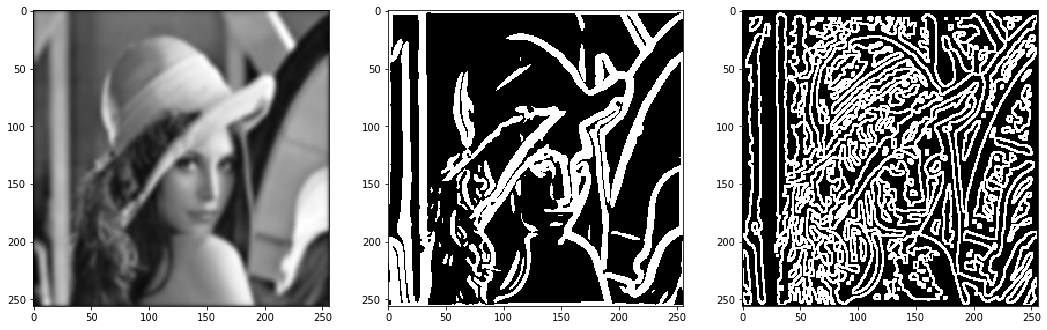

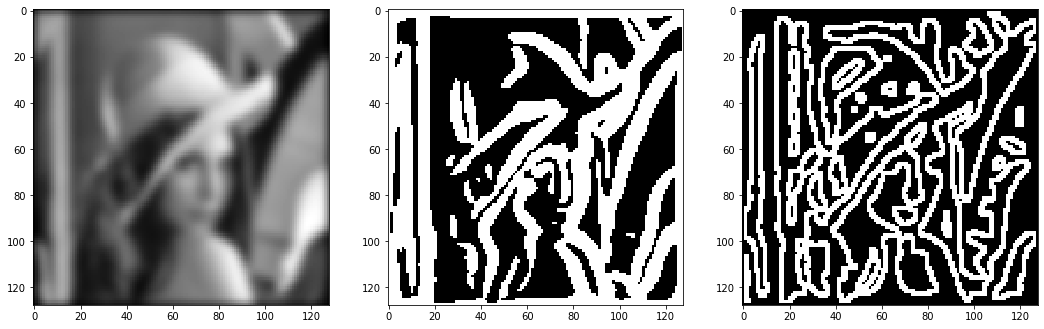

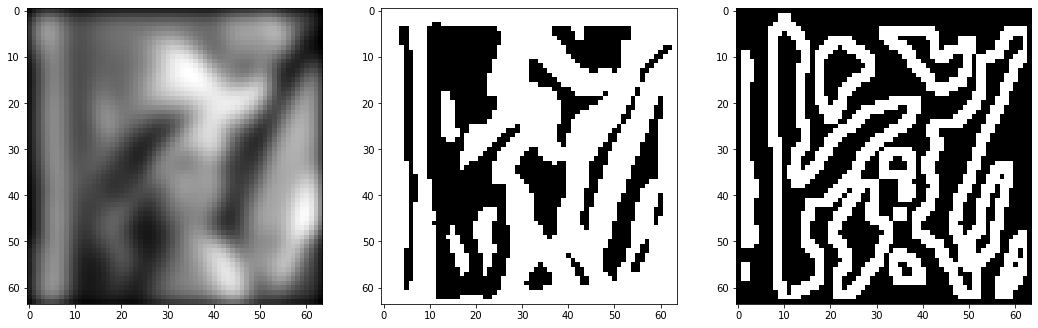

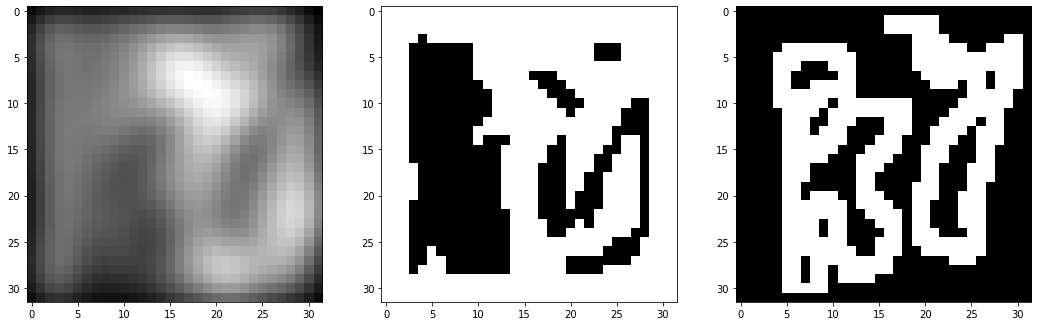

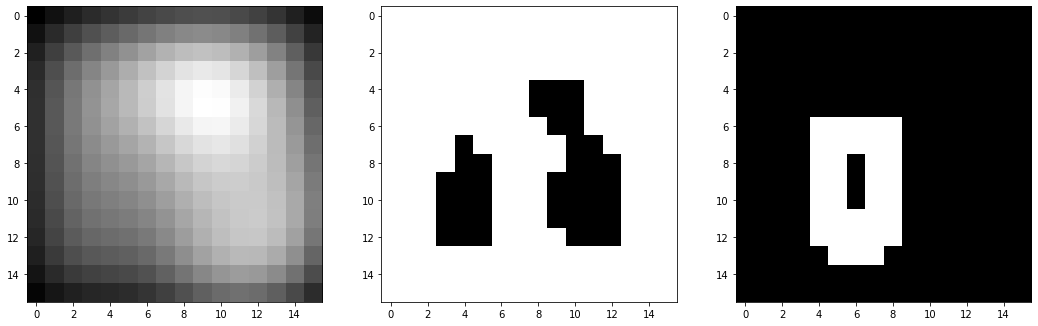

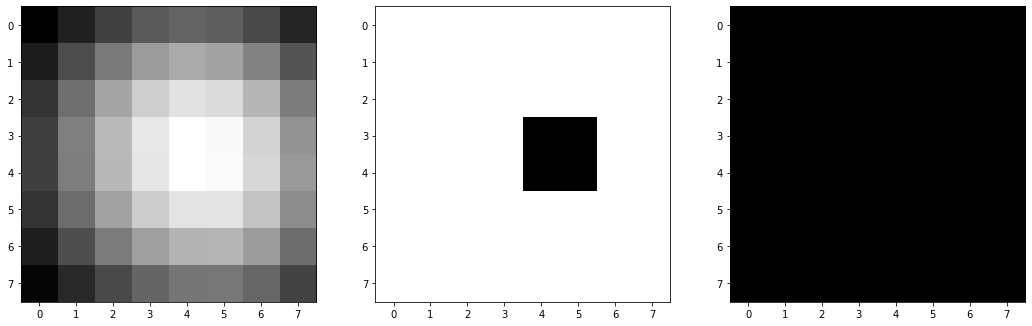

In [16]:
tmp = multi_resolution(lena, 4, True)
for i in tmp:
    niceDisplay14([i,SobelDetector(i,50), LaplacianDetector(i,0.1)])

On observe bien que le filtre de Laplace est une dérivé seconde et le filtre de Nobel une dérivée première. Les formes du premier semblant plus ou moins correspondre aux contours du second.  
Plus on echantillonage l'image, plus les bords détéctés sont larges (mal localisés) et les contours détéctés sont moins nombreux.
Plus la définition ce réduit moins le résultat est précis.  
On peut remarquer que le filtre de nobel est plus efficace en basse dimension que le filtre Laplacian qui n'affiche plus rien en dessous d'une dimension (16, 16).


# Hysteresis thresholding

Petit bonus avec un double seuillage et hystérèse.

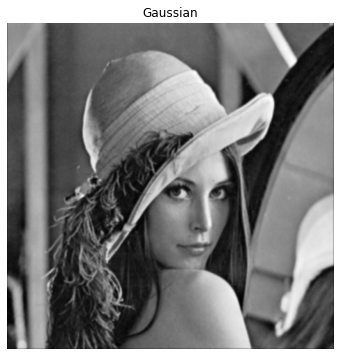

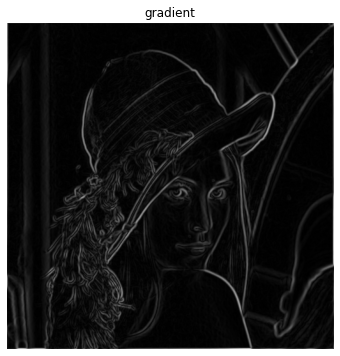

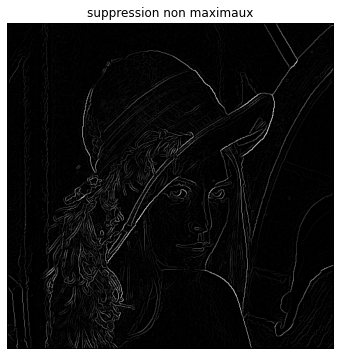

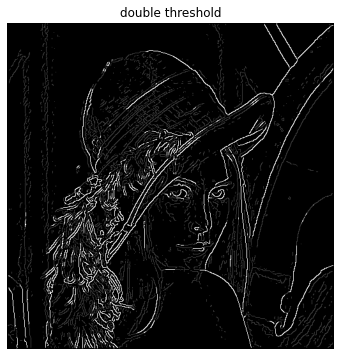

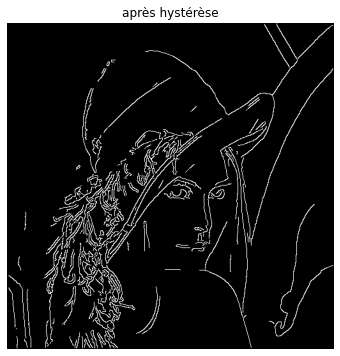

In [28]:
'''
Etapes :
1 : suppression du bruit avec un filtre gaussien
2 : realisation du Gradient
3 : suppression des non maximaux
4 : double seuillage sur les gradients restants (normalisé sur 255)
5 : realisation de l'hystérèse
'''
def sobel(I):
    Ix = convolve2d(I,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
    Iy = convolve2d(I,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
    G = np.sqrt(Ix**2+Iy**2)
    return G / G.max() * 255
    
def threshold(img,low,high):
    res = np.zeros(img.shape)
    highvalues_i, highvalues_j = np.where(img>=high)
    lowvalues_i, lowvalues_j = np.where((img <= high) & (img>=low))
    res[highvalues_i, highvalues_j] = high
    res[lowvalues_i, lowvalues_j] = low
    return (res,low,high)

def hysteresis(img,low,high):
    N, M = img.shape
    for i in range(1,N-1):
        for j in range(1,M-1):
            if(img[i][j] == low):
                try:
                    if ((img[i+1, j-1] == high) or (img[i+1, j] == high) or (img[i+1, j+1] == high)
                        or (img[i, j-1] == high) or (img[i, j+1] == high)
                        or (img[i-1, j-1] == high) or (img[i-1, j] == high) or (img[i-1, j+1] == high)):
                        img[i, j] = high
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

lena_c = applyGaussian(lena,1)
imshow(lena_c,"Gaussian")
Ix_l = convolve2d(lena_c,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
Iy_l = convolve2d(lena_c,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
Ig_l = np.sqrt(Ix_l**2+Iy_l**2)

lena_c =  Ig_l / Ig_l.max() * 255
imshow(lena_c,"gradient")
orient_l = orientation(Ix_l,Iy_l,Ig_l)
lena_c = nms(Ig_l,orient_l)
imshow(lena_c,"suppression non maximaux")
lena_c, low, high = threshold(lena_c,30,120)
imshow(lena_c,"double threshold")
lena_c = hysteresis(lena_c,low,high)

imshow(lena_c,"après hystérèse")



réalisé avec l'aide de :
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123